# Consumer Reviews Summarization - Project Part 2


[![Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/Ariamestra/ConsumerReviews/blob/main/project_part2.ipynb)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Ariamestra/ConsumerReviews/blob/main/project_part2.ipynb)


## 1. Introduction
My project goal is to develop a baseline model using a Naive Bayes classifier, designed to summarize customer reviews. This is intended to help potential buyers quickly navigate through reviews when assessing a product. The system will focus on condensing the essential content of each review and its associated rating into a concise, single-sentence comment. These comments will be categorized as positive, neutral, or negative, aligning with the review's original rating. This approach will simplify the review evaluation process, making it more efficient.<br>
<br>
**Data** <br>
The dataset was sourced from Kaggle, specifically the [Consumer Review of Clothing Product](https://www.kaggle.com/datasets/jocelyndumlao/consumer-review-of-clothing-product)
 dataset. This dataset includes customer reviews from Amazon. It has all sorts of feedback from buyers about different products. Along with the customers' actual reviews, ratings, product type, material, construction, color, finish, and durability.<br>



## Prep

In [81]:
# Import all of the Python Modules/Packages 
#!pip install -U imbalanced-learn
#!pip install keras
#!pip install tensorflow
#!pip install wordcloud

import pandas as pd
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
import matplotlib.pyplot as plt
import seaborn as sns
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from nltk.probability import FreqDist
from heapq import nlargest
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE # Data transformer because when split traning data it 99% positive
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
import numpy as np
from sklearn.metrics import confusion_matrix

from wordcloud import WordCloud
import random



from nltk.probability import FreqDist


# Now download NLTK resources
#nltk.download('stopwords')
#nltk.download('punkt')

data_URL = 'https://raw.githubusercontent.com/Ariamestra/ConsumerReviews/main/Reviews.csv'
df = pd.read_csv(data_URL)
print(f"Shape: {df.shape}")
df.head()

Shape: (49338, 9)


,Title,Review,Cons_rating,Cloth_class,Materials,Construction,Color,Finishing,Durability
0,NaN,Absolutely wonderful - silky and sexy and comf...,4.0,Intimates,0.0,0.0,0.0,1.0,0.0
1,NaN,Love this dress! it's sooo pretty. i happene...,5.0,Dresses,0.0,1.0,0.0,0.0,0.0
2,Some major design flaws,I had such high hopes for this dress and reall...,3.0,Dresses,0.0,0.0,0.0,1.0,0.0
3,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5.0,Pants,0.0,0.0,0.0,0.0,0.0
4,Flattering shirt,This shirt is very flattering to all due to th...,5.0,Blouses,0.0,1.0,0.0,0.0,0.0


In [82]:
# Count the number of nulls in reviews
number_of_nulls = df['Review'].isnull().sum()
print(f"Number of nulls in the reviews: {number_of_nulls}")

# Calculate the number of nulls in rating
number_of_nulls_in_ratings = df['Cons_rating'].isnull().sum()
print(f"Number of nulls in the ratings: {number_of_nulls_in_ratings}")

original_count = df.shape[0]
df_cleaned = df.dropna(subset=['Review', 'Cons_rating']) # Drop rows with nulls in reviews and ratings columns
cleaned_count = df_cleaned.shape[0] # Number of rows after dropping nulls
rows_dropped = original_count - cleaned_count

print(f"Number of rows dropped: {rows_dropped}")

# Get the shape after dropping null values
df_shape_after_dropping = df_cleaned.shape

print(f"Shape of the DataFrame after dropping rows: {df_shape_after_dropping}")


Number of nulls in the reviews: 831
Number of nulls in the ratings: 214
Number of rows dropped: 1043
Shape of the DataFrame after dropping rows: (48295, 9)


In [83]:
# Review length of reviews
df_cleaned = df_cleaned.copy()
df_cleaned['Review_length'] = df_cleaned['Review'].apply(lambda x: len(str(x).split()))

# Filter out reviews that are shorter than 20 words 
df_cleaned.drop(df_cleaned[df_cleaned['Review_length'] < 20].index, inplace=True)

# Longest and shortest reviews in df_cleaned
longest_review_row = df_cleaned.loc[df_cleaned['Review_length'].idxmax()]
longest_review = longest_review_row['Review']
longest_review_length = longest_review_row['Review_length']

shortest_review_row = df_cleaned.loc[df_cleaned['Review_length'].idxmin()]
shortest_review = shortest_review_row['Review']
shortest_review_length = shortest_review_row['Review_length']

print(f"Longest review length: {longest_review_length} words")
print(f"Shortest review length: {shortest_review_length} words")
print(f"Shape of the DataFrame after dropping rows below 20 words: {df_cleaned.shape}")

Longest review length: 668 words
Shortest review length: 20 words
Shape of the DataFrame after dropping rows below 20 words: (32857, 10)


In [84]:
# Clean reviews
stop_words = set(stopwords.words('english'))

def clean_review(review):
    review = str(review).lower()
    review = review.translate(str.maketrans('', '', string.punctuation))
    # Tokenize and remove stop words
    words = word_tokenize(review)
    words = [word for word in words if word.isalpha() and word not in stop_words]
    # Join string
    review = ' '.join(words)
    return review

print(f"Done")

Done


In [85]:
# Converts it to a numerical format using TF-IDF vectorization and then splits the dataset into training and test sets.

df_cleaned['Processed_Review'] = df_cleaned['Review'].apply(clean_review)

tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words='english', max_df=0.95, min_df=0.05)

X = tfidf_vectorizer.fit_transform(df_cleaned['Processed_Review'])

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df_cleaned['Cons_rating'])

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Calculate the total number 
total_samples = X.shape[0]
train_size = X_train.shape[0]
test_size = X_test.shape[0]


train_percentage = (train_size / total_samples) * 100
test_percentage = (test_size / total_samples) * 100

print(f"Total dataset size: {total_samples}")
print(f"Train size: {train_size} ({train_percentage:.2f}%)")
print(f"Test size: {test_size} ({test_percentage:.2f}%)")


Total dataset size: 32857
Train size: 26285 (80.00%)
Test size: 6572 (20.00%)


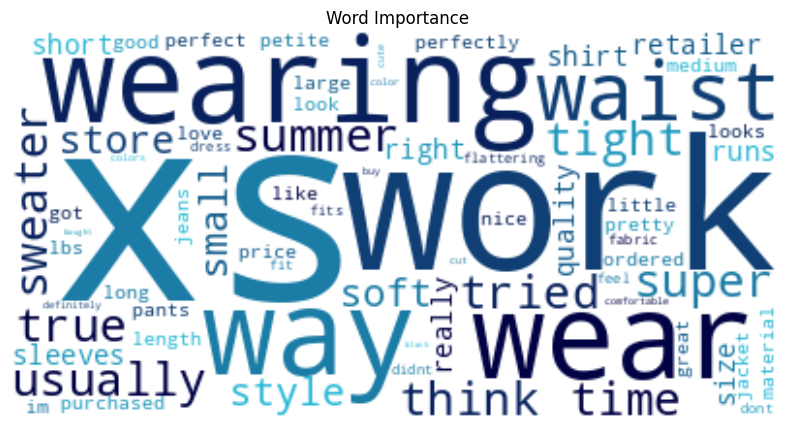

In [86]:
# Visualize the most significant words after TF-IDF 
# Define color 
def color_func(word, font_size, position, orientation, random_state=None, **kwargs): 
    colors = ['#020344', '#08215C', '#0F3F74', '#155E8D', '#1B7CA5', '#229ABD', '#28B8D5'] 
    return random.choice(colors) 

wordcloud = WordCloud(background_color='white', color_func=color_func).fit_words(tfidf_vectorizer.vocabulary_) 
plt.figure(figsize=(10, 10)) 
plt.imshow(wordcloud, interpolation='bilinear') 
plt.axis('off') 
plt.title('Word Importance') 
plt.show() # Visualize the distribution of encoded ratings 


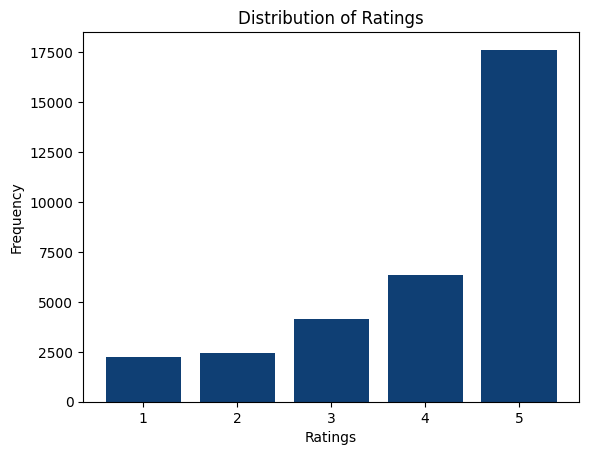

In [87]:
# Visualize the distribution of encoded ratings 

unique_labels = np.unique(y)
counts = np.bincount(y)

fig, ax = plt.subplots()
ax.bar(unique_labels, counts, color='#0F3F74')

ax.set_xticks(unique_labels)
original_labels = ['1', '2', '3', '4', '5'] 
ax.set_xticklabels(original_labels)

ax.set_xlabel('Ratings')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of Ratings')
plt.show()


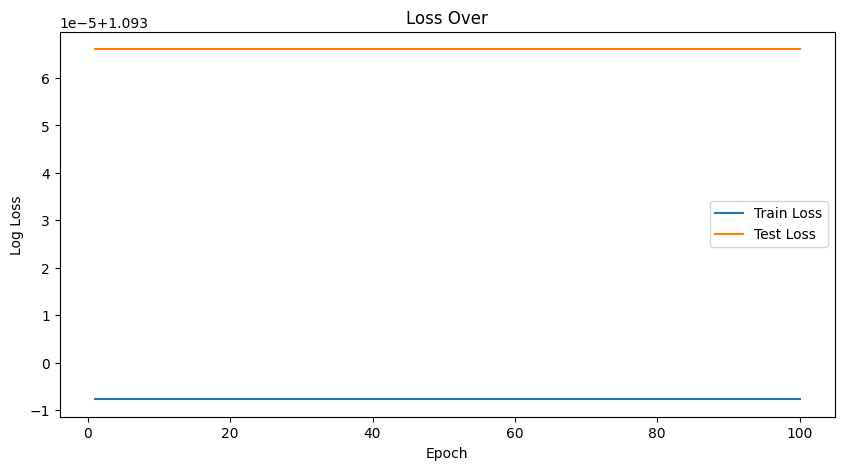

In [88]:
# ------------------------------------ Is it being done correctly????----------------------Loss Curve----------------------------------
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LogisticRegression(solver='lbfgs', max_iter=1000))

model.fit(X_train, y_train)

# Initialize lists to store the loss values
train_losses = []
test_losses = []


for epoch in range(1, 101):  # Assuming you want to train for 100 epochs
    
    # Predict probabilities for the training and test sets
    train_pred_prob = model.predict_proba(X_train)
    test_pred_prob = model.predict_proba(X_test)
    
    # Calculate the log loss for the training and test sets
    train_loss = log_loss(y_train, train_pred_prob)
    test_loss = log_loss(y_test, test_pred_prob)
    
    # Store the log loss values
    train_losses.append(train_loss)
    test_losses.append(test_loss)


plt.figure(figsize=(10, 5))
plt.plot(range(1, 101), train_losses, label='Train Loss')
plt.plot(range(1, 101), test_losses, label='Test Loss')
plt.title('Loss Over')
plt.xlabel('Epoch')
plt.ylabel('Log Loss')
plt.legend()
plt.show()


Train the Naive Bayes classifier

In [89]:
'''
# Apply SMOTE to the training data ----------------- May need to delete ---------------------------
X_tfidf = tfidf_vectorizer.fit_transform(df_cleaned['Processed_Review'])
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
'''

"\n# Apply SMOTE to the training data ----------------- May need to delete ---------------------------\nX_tfidf = tfidf_vectorizer.fit_transform(df_cleaned['Processed_Review'])\nsmote = SMOTE(random_state=42)\nX_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)\n"

Basline model

In [90]:
# Model Training
model = MultinomialNB()

model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))


Accuracy: 0.5366707242848447


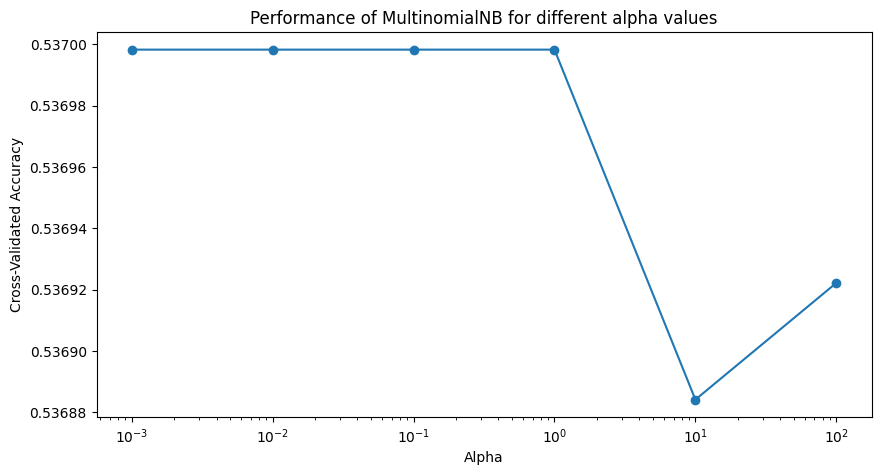

Best alpha: 0.001
Best cross-validated score: 0.5369982879969565


In [91]:
# Using grid search and visualize data - Model tuning plot
# --------------------------------------- Needs to fix or maybe delete -------------------------------

alpha_values = [0.001, 0.01, 0.1, 1, 10, 100]
param_grid = {'alpha': alpha_values}

nb_classifier = MultinomialNB()

grid_search = GridSearchCV(nb_classifier, param_grid, cv=5, scoring='accuracy')

grid_search.fit(X_train, y_train)

mean_test_scores = grid_search.cv_results_['mean_test_score']

plt.figure(figsize=(10, 5))
plt.plot(alpha_values, mean_test_scores, marker='o')
plt.xscale('log')
plt.xlabel('Alpha')
plt.ylabel('Cross-Validated Accuracy')
plt.title('Performance of MultinomialNB for different alpha values')
plt.show()

best_alpha = grid_search.best_params_['alpha']
best_score = grid_search.best_score_

print(f"Best alpha: {best_alpha}")
print(f"Best cross-validated score: {best_score}")


In [92]:
'''
# Sentiment
df['Sentiment_Summary'] = df['Cons_rating'].apply(lambda x: 'Negative' if x < 3 else ('Neutral' if x == 3 else 'Positive'))

df['Review_length'] = df['Review'].apply(lambda x: len(str(x).split()))

df_long_reviews = df[df['Review_length'] > 20]


for index, row in df_long_reviews.head(15).iterrows():
    print("Original Review:", row['Review'])
    print("Predicted Sentiment:", row['Sentiment_Summary'])
    print('-' * 100)
'''

'\n# Sentiment\ndf[\'Sentiment_Summary\'] = df[\'Cons_rating\'].apply(lambda x: \'Negative\' if x < 3 else (\'Neutral\' if x == 3 else \'Positive\'))\n\ndf[\'Review_length\'] = df[\'Review\'].apply(lambda x: len(str(x).split()))\n\ndf_long_reviews = df[df[\'Review_length\'] > 20]\n\n\nfor index, row in df_long_reviews.head(15).iterrows():\n    print("Original Review:", row[\'Review\'])\n    print("Predicted Sentiment:", row[\'Sentiment_Summary\'])\n    print(\'-\' * 100)\n'

In [93]:
# Summarize text reviews by extracting key words

# Summarize_review function
def summarize_review(review, rating, num_sentences=2):

    stopWords = set(stopwords.words("english"))
    words = word_tokenize(review.lower()) 

    freqTable = FreqDist(words)
    sentences = sent_tokenize(review)
    sentenceValue = dict()

    for sentence in sentences:
        for word, freq in freqTable.items():
            if word in sentence.lower():
                if sentence in sentenceValue:
                    sentenceValue[sentence] += freq
                else:
                    sentenceValue[sentence] = freq

    summary_sentences = nlargest(num_sentences, sentenceValue, key=sentenceValue.get)
    summary = ' '.join(summary_sentences)

    # Determine the sentiment based on the rating
    sentiment = ''
    if rating < 3:
        sentiment = 'Negative'
    elif rating == 3:
        sentiment = 'Neutral'
    else:
        sentiment = 'Positive'

    # Adjust sentence scores based on the determined sentiment
    if sentiment == 'Negative':
        negative_sentiment_words = ['bad', 'worst', 'terrible']  
        for sentence in sentences:
            if any(negative_word in sentence.lower() for negative_word in negative_sentiment_words):
                sentenceValue[sentence] *= 1.5 
    return summary

# Clean
df['Review'] = df['Review'].astype(str)
df['Word_Count'] = df['Review'].apply(lambda x: len(x.split()))
mask = df['Word_Count'] >= 20
df = df[mask]

def determine_sentiment(rating):
    if rating < 3:
        return 'Negative'
    elif rating == 3:
        return 'Neutral'
    else:
        return 'Positive'

# Apply the summarization 
df['Summarized_Review'] = df.apply(lambda x: summarize_review(x['Review'], x['Cons_rating'], num_sentences=2), axis=1)

for index, row in df.head(15).iterrows():
    original_review = row['Review']
    summarized_review = row['Summarized_Review']
    
    sentiment = determine_sentiment(row['Cons_rating'])

    original_word_count = len(original_review.split())
    summarized_word_count = len(summarized_review.split())

    print("Original Review:", original_review)
    print("Original Review Word Count:", original_word_count)
    print("Original Review Sentiment:", sentiment)  
    print()
    print("Summarized Review:", summarized_review)
    print("Summarized Review Word Count:", summarized_word_count)
    print('-' * 100)


Original Review: Love this dress!  it's sooo pretty.  i happened to find it in a store, and i'm glad i did bc i never would have ordered it online bc it's petite.  i bought a petite and am 5'8".  i love the length on me- hits just a little below the knee.  would definitely be a true midi on someone who is truly petite.
Original Review Word Count: 62
Original Review Sentiment: Positive

Summarized Review: i happened to find it in a store, and i'm glad i did bc i never would have ordered it online bc it's petite. would definitely be a true midi on someone who is truly petite.
Summarized Review Word Count: 36
----------------------------------------------------------------------------------------------------
Original Review: I had such high hopes for this dress and really wanted it to work for me. i initially ordered the petite small (my usual size) but i found this to be outrageously small. so small in fact that i could not zip it up! i reordered it in petite medium, which was just ok. o

## Conclusion
The project's goal was to create a baseline model using Naive Bayes to summarize textual reviews while taking into account the sentiment expressed by each review's rating. By cleaning the text data by removing stopwords, tokenizing, and leveraging frequency distributions of words I developed a summarization function that captures the essence of longer reviews and summerizes them.